In [77]:
import tensorflow as tf


In [2]:
import torch



In [3]:
!pip install transformers

In [78]:
import numpy as np
import pandas as pd
import warnings
import datetime
import re

import torch # a tensor library
# the huggingface transformers library (pre-trained deep learning for NLP models)
# run !pip install transformers in a Jupyter Notebook cell
import transformers as ppb 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [87]:
# IF JUST USE THE TRAINING DATA
df = pd.read_csv("train.csv")
df['len_txt'] =df.cleaned_contents.apply(lambda x: len(x.split()))
df = df[df.len_txt >249]
df = df[df.len_txt <20000]
df = df[['cleaned_contents', 'Discrimination_Label']]
df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
df['text'] = df['text'].str.lower()
df['text'] = pd.Series(re.sub(r'(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)([\s]{1,3})?([0-9]{1,2})(.{1,3})?((,)|(.))?([\s]{1,3})?([0-9]{4})|([0-9]{1,2})(.{1,3})?([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|eleventh|twelfth|thirteenth|fourteenth|fifteenth|sixteenth|seventeenth|eighteenth|nineteenth|twentieth|twenty-first|twenty-second|twenty-third|twenty-fourth|twenty-fifth|twenty-sixth|twenty-seventh|twenty-eighth|twenty-ninth|thirtieth|thirty-first)([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(\b[0-9]{1,2}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{2,4}\b)|(\b[0-9]{2,4}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{1,2}\b)', '[DATE]', i) for i in df['text'])
#remove special character
#df['text'] = pd.Series(re.sub("'", "", i) for i in df['text'])
#df['text'] = pd.Series(re.sub("(\\W)+", " ", i) for i in df['text'])
df = df.replace({'text': {"'": ""}}, regex=True)
df = df.replace({'text': {"(\\W)+": " "}}, regex=True)
df.dropna(subset = ["text"], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,text,label
0,sentence 1 you are charged as follows first co...,0
1,sentence 1 josefa kotobalavu you were charged ...,1
2,sentence 1 the director of public prosecution ...,1
3,sentence 1 mohommed nabi ud dean you were conv...,1
4,judgment of the court background 1 the appella...,0


In [74]:
# IF USE BOTH TRAINING AND TEST (THIS MEANS WE HAVE NOTHING TO PREDICT AGAINST AS HOLDOUT)
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
df = pd.concat([train_data,test_data])
df['len_txt'] =df.cleaned_contents.apply(lambda x: len(x.split()))
df = df[df.len_txt >249]
df = df[df.len_txt <20000]
df = df[['cleaned_contents', 'Discrimination_Label']]
df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
#lower case to help remove dates
df['text'] = df['text'].str.lower()
#remove dates
df['text'] = pd.Series(re.sub(r'(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)([\s]{1,3})?([0-9]{1,2})(.{1,3})?((,)|(.))?([\s]{1,3})?([0-9]{4})|([0-9]{1,2})(.{1,3})?([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|eleventh|twelfth|thirteenth|fourteenth|fifteenth|sixteenth|seventeenth|eighteenth|nineteenth|twentieth|twenty-first|twenty-second|twenty-third|twenty-fourth|twenty-fifth|twenty-sixth|twenty-seventh|twenty-eighth|twenty-ninth|thirtieth|thirty-first)([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(\b[0-9]{1,2}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{2,4}\b)|(\b[0-9]{2,4}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{1,2}\b)', '[DATE]', i) for i in df['text'])
#remove special character
df['text'] = pd.Series(re.sub("'", "", i) for i in df['text'])
df['text'] = pd.Series(re.sub("(\\W)+", " ", i) for i in df['text'])

df.reset_index(inplace=True, drop=True)
df.head()


,text,label
0,sentence 1 you are charged as follows first co...,0
1,sentence 1 josefa kotobalavu you were charged ...,1
2,sentence 1 the director of public prosecution ...,1
3,sentence 1 mohommed nabi ud dean you were conv...,1
4,judgment of the court background 1 the appella...,0


In [89]:


# we need a BERT model and a BERT tokenizer
# initialize the empty model and tokenizer objects
# we are going to use the Hugging Face's DistilBert model
BERT_model_class,BERT_tokenizer_class,BERT_pre_trained_weights = (ppb.DistilBertModel, # the pre-trained DistillBERT model
                                                                  ppb.DistilBertTokenizer,
                                                                  'distilbert-base-uncased') # the type of DistilBERT model

# use the next line instead, if you want (Google's) BERT instead of DistillBERT
#BERT_model_class,BERT_tokenizer_class,BERT_pre_trained_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

# Load pretrained model/tokenizer weights/values for the desired type of BERT model into their respective objects
tokenizer = BERT_tokenizer_class.from_pretrained(BERT_pre_trained_weights)

#model1 is a pytorch BERT model
#model1 = BERT_model_class.from_pretrained('distilbert-base-uncased')




In [90]:

tokenizer = BERT_tokenizer_class.from_pretrained(BERT_pre_trained_weights)
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))
# This turns every sentence into a list of IDs
# tokenized is apandas Series object: <class 'pandas.core.series.Series'>
print(df.head())
print('\n')
print(tokenized.head())
print('\n')
print(tokenized.shape) #(6920,) a 1D pandas Series
print(type(tokenized)) #<class 'pandas.core.series.Series'>

                                                text  label
0  sentence 1 you are charged as follows first co...      0
1  sentence 1 josefa kotobalavu you were charged ...      1
2  sentence 1 the director of public prosecution ...      1
3  sentence 1 mohommed nabi ud dean you were conv...      1
4  judgment of the court background 1 the appella...      0


0    [101, 6251, 1015, 2017, 2024, 5338, 2004, 4076...
1    [101, 6251, 1015, 12947, 2050, 12849, 3406, 25...
2    [101, 6251, 1015, 1996, 2472, 1997, 2270, 1153...
3    [101, 6251, 1015, 9587, 23393, 7583, 6583, 563...
4    [101, 8689, 1997, 1996, 2457, 4281, 1015, 1996...
Name: text, dtype: object


(641,)
<class 'pandas.core.series.Series'>


In [91]:
print(f'tokenized.values.shape: {tokenized.values.shape}')
# find the length of the longest sentence in the dataset
max_len = 0
for i in tokenized.values:  #tokenized.values is of type #<class 'numpy.ndarray'>
    if len(i) > max_len:
        max_len = len(i)
print(f'max sentence length is : {max_len}')
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(f'padded.shape: {padded.shape}')

tokenized.values.shape: (641,)
max sentence length is : 512
padded.shape: (641, 512)


In [92]:
print(tokenized[0])
print('\n')
print(padded[0])
print(f'\nlen(padded[0]): {len(padded[0])}')

[101, 6251, 1015, 2017, 2024, 5338, 2004, 4076, 2034, 4175, 4861, 1997, 15226, 9040, 10043, 2000, 5433, 17332, 1998, 5018, 1997, 1996, 18476, 3642, 6178, 2459, 3327, 2015, 1997, 15226, 14262, 14545, 2401, 3972, 2050, 2090, 1996, 3058, 2000, 3058, 2012, 23233, 12260, 2072, 2352, 12436, 8525, 24861, 2721, 11937, 19722, 2050, 1999, 1996, 2530, 2407, 2018, 22300, 2482, 12032, 3716, 1997, 1050, 2078, 2302, 2014, 9619, 2117, 4175, 4861, 1997, 15226, 9040, 10043, 2000, 2930, 19843, 1015, 1998, 1016, 1037, 1997, 1996, 6997, 10037, 4008, 1997, 2268, 3327, 2015, 1997, 15226, 14262, 14545, 2401, 3972, 2050, 2090, 1996, 3058, 2000, 1996, 3058, 2012, 23233, 12260, 2072, 2352, 12436, 8525, 24861, 2721, 11937, 19722, 2050, 1999, 1996, 2530, 2407, 21653, 1996, 12436, 20876, 1997, 1050, 2078, 2007, 2010, 19085, 2302, 2014, 9619, 1015, 2006, 3058, 2017, 12254, 5905, 2000, 2119, 5571, 2114, 2017, 1998, 4914, 1996, 12654, 1997, 8866, 2006, 3058, 1016, 1996, 12654, 1997, 8866, 7864, 2011, 1996, 2110, 9517,

In [93]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(641, 512)

In [94]:
print(attention_mask[0])
print(attention_mask[1])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [95]:
#create a tensor for the attention_mask
attention_mask = torch.tensor(attention_mask)
#We now create an input tensor out of the padded token matrix, and send that to DistilBERT
input_ids = torch.tensor(padded) 
#the model() function runs our sentence
# convert labels to tensor 
labels = df['label']
labels = torch.tensor(labels)

#Divide up our training set to use 90% for training and 10% for validation.
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_mask, labels)

In [97]:
# Create a 80-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  576 training samples
   65 validation samples


In [98]:
# USe pytorch dataloader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [99]:
torch.cuda.empty_cache()

In [100]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [101]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [102]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [103]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [104]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



In [105]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [106]:
torch.cuda.empty_cache()

In [107]:
import random
import numpy as np

device = torch.device("cuda")

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     72.    Elapsed: 0:01:00.

  Average training loss: 0.77
  Training epcoh took: 0:01:49

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     72.    Elapsed: 0:01:01.

  Average training loss: 0.70
  Training epcoh took: 0:01:49

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     72.    Elapsed: 0:01:00.

  Average training loss: 0.70
  Training epcoh took: 0:01:49

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.68
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     72.    Elapsed: 0:01:01.

  Average training loss: 0.69
  Training epcoh took: 0:01:49

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.69
  Validation took: 0:00:04

Training complete!
Total tr

In [108]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.77,0.68,0.57,0:01:49,0:00:04
2,0.70,0.68,0.57,0:01:49,0:00:04
3,0.70,0.68,0.57,0:01:49,0:00:04
4,0.69,0.69,0.57,0:01:49,0:00:04


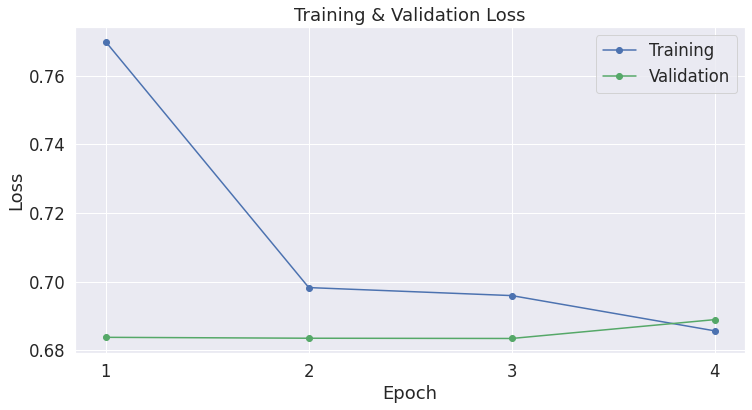

In [109]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [110]:
# Holdout
import pandas as pd

# Load the dataset into a pandas dataframe.
# IF JUST USE THE TRAINING DATA
df = pd.read_csv("test.csv")
df['len_txt'] =df.cleaned_contents.apply(lambda x: len(x.split()))
df = df[df.len_txt >249]
df = df[df.len_txt <20000]
df = df[['cleaned_contents', 'Discrimination_Label']]
df = df.rename(columns = {'cleaned_contents':'text', 'Discrimination_Label':'label'})
df['text'] = df['text'].str.lower()
df['text'] = pd.Series(re.sub(r'(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)([\s]{1,3})?([0-9]{1,2})(.{1,3})?((,)|(.))?([\s]{1,3})?([0-9]{4})|([0-9]{1,2})(.{1,3})?([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(first|second|third|fourth|fifth|sixth|seventh|eighth|ninth|tenth|eleventh|twelfth|thirteenth|fourteenth|fifteenth|sixteenth|seventeenth|eighteenth|nineteenth|twentieth|twenty-first|twenty-second|twenty-third|twenty-fourth|twenty-fifth|twenty-sixth|twenty-seventh|twenty-eighth|twenty-ninth|thirtieth|thirty-first)([\s]{1,3})?(day)?([\s]{1,3})?(of)?([\s]{1,3})?(jan(uary)?|feb(ruary)?|mar(ch)?|apr(il)?|may|jun(e)?|jul(y)?|aug(ust)?|sep(t)?(tember)?|oct(ober)?|nov(ember)?|dec(ember)?)((,)|(.))?(\s{1,3})?([0-9]{4})|(\b[0-9]{1,2}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{2,4}\b)|(\b[0-9]{2,4}(\-|\/)[0-9]{1,2}(\-|\/)[0-9]{1,2}\b)', '[DATE]', i) for i in df['text'])
#remove special character
#df['text'] = pd.Series(re.sub("'", "", i) for i in df['text'])
#df['text'] = pd.Series(re.sub("(\\W)+", " ", i) for i in df['text'])
df = df.replace({'text': {"'": ""}}, regex=True)
df = df.replace({'text': {"(\\W)+": " "}}, regex=True)
df.dropna(subset = ["text"], inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()



,text,label
0,sentence name of the victim is suppressed she ...,1
1,judgment this is an appeal against conviction ...,1
2,judgment 1 on DATE the appellant william raymo...,1
3,judgment 1 on the DATE in the nasinu magistrat...,0
4,sentence background 1 the accused was charged ...,1


In [111]:
tokenizer = BERT_tokenizer_class.from_pretrained(BERT_pre_trained_weights)
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))
# This turns every sentence into a list of IDs
# tokenized is apandas Series object: <class 'pandas.core.series.Series'>
print(df.head())
print('\n')
print(tokenized.head())
print('\n')
print(tokenized.shape) #(162,) a 1D pandas Series
print(type(tokenized)) #<class 'pandas.core.series.Series'>

                                                text  label
0  sentence name of the victim is suppressed she ...      1
1  judgment this is an appeal against conviction ...      1
2  judgment 1 on DATE the appellant william raymo...      1
3  judgment 1 on the DATE in the nasinu magistrat...      0
4  sentence background 1 the accused was charged ...      1


0    [101, 6251, 2171, 1997, 1996, 6778, 2003, 1371...
1    [101, 8689, 2023, 2003, 2019, 5574, 2114, 1065...
2    [101, 8689, 1015, 2006, 3058, 1996, 10439, 241...
3    [101, 8689, 1015, 2006, 1996, 3058, 1999, 1996...
4    [101, 6251, 4281, 1015, 1996, 5496, 2001, 5338...
Name: text, dtype: object


(162,)
<class 'pandas.core.series.Series'>


In [114]:
#create a tensor for the attention_mask
attention_mask = torch.tensor(attention_mask)
#We now create an input tensor out of the padded token matrix, and send that to DistilBERT
input_ids = torch.tensor(padded) 
#the model() function runs our sentence
# convert labels to tensor 
labels = df['label']
labels = torch.tensor(labels)



In [116]:
# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_mask, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [117]:
# Evaluate
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 162 test sentences...
    DONE.


In [118]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 97 of 162 (59.88%)


In [129]:
len(true_labels)

21

In [132]:
print(true_labels)

[array([1, 1, 1, 0, 1, 1, 1, 0]), array([0, 1, 1, 0, 1, 1, 1, 1]), array([1, 1, 0, 1, 0, 1, 1, 1]), array([1, 0, 0, 0, 0, 1, 0, 1]), array([1, 0, 0, 1, 0, 1, 0, 1]), array([0, 0, 1, 1, 1, 0, 1, 1]), array([1, 1, 1, 1, 1, 0, 0, 0]), array([1, 1, 1, 1, 0, 1, 0, 1]), array([0, 0, 0, 1, 1, 1, 1, 0]), array([1, 0, 0, 1, 1, 1, 1, 1]), array([0, 0, 1, 1, 1, 1, 0, 1]), array([0, 0, 1, 0, 1, 1, 1, 1]), array([1, 1, 0, 0, 1, 1, 1, 1]), array([1, 0, 1, 0, 0, 0, 1, 0]), array([0, 1, 1, 1, 0, 1, 0, 0]), array([1, 1, 0, 0, 1, 1, 1, 1]), array([0, 0, 1, 0, 0, 0, 0, 0]), array([1, 0, 1, 1, 0, 1, 0, 1]), array([1, 1, 0, 1, 0, 0, 0, 0]), array([1, 0, 1, 1, 1, 0, 1, 1]), array([1, 1])]


In [139]:
print(predictions)

[array([[-0.03078638,  0.46211198],
       [-0.02976584,  0.46293426],
       [-0.03101056,  0.46121714],
       [-0.03012421,  0.46278536],
       [-0.03042751,  0.46268833],
       [-0.030663  ,  0.4622148 ],
       [-0.02965624,  0.4632329 ],
       [-0.03062444,  0.4620274 ]], dtype=float32), array([[-0.03071432,  0.4622516 ],
       [-0.03002898,  0.46180037],
       [-0.0301637 ,  0.46227825],
       [-0.03079856,  0.46179354],
       [-0.02964677,  0.46170032],
       [-0.02983115,  0.4622293 ],
       [-0.02983773,  0.46259096],
       [-0.02982606,  0.4620067 ]], dtype=float32), array([[-0.02997181,  0.46230653],
       [-0.03025569,  0.46303916],
       [-0.0309477 ,  0.46114233],
       [-0.03091851,  0.4612416 ],
       [-0.02949068,  0.46219367],
       [-0.03024698,  0.46110308],
       [-0.03019177,  0.462166  ],
       [-0.02950762,  0.46187317]], dtype=float32), array([[-0.03016361,  0.46160263],
       [-0.03181884,  0.46091896],
       [-0.03049608,  0.46193135],
   

In [146]:
preds = np.concatenate( predictions, axis=0 )
tl = np.concatenate( true_labels, axis=0 )

In [151]:
# The model has predicted everything as positive. 
print(preds)

[[-0.03078638  0.46211198]
 [-0.02976584  0.46293426]
 [-0.03101056  0.46121714]
 [-0.03012421  0.46278536]
 [-0.03042751  0.46268833]
 [-0.030663    0.4622148 ]
 [-0.02965624  0.4632329 ]
 [-0.03062444  0.4620274 ]
 [-0.03071432  0.4622516 ]
 [-0.03002898  0.46180037]
 [-0.0301637   0.46227825]
 [-0.03079856  0.46179354]
 [-0.02964677  0.46170032]
 [-0.02983115  0.4622293 ]
 [-0.02983773  0.46259096]
 [-0.02982606  0.4620067 ]
 [-0.02997181  0.46230653]
 [-0.03025569  0.46303916]
 [-0.0309477   0.46114233]
 [-0.03091851  0.4612416 ]
 [-0.02949068  0.46219367]
 [-0.03024698  0.46110308]
 [-0.03019177  0.462166  ]
 [-0.02950762  0.46187317]
 [-0.03016361  0.46160263]
 [-0.03181884  0.46091896]
 [-0.03049608  0.46193135]
 [-0.03081063  0.4622715 ]
 [-0.03068995  0.46257007]
 [-0.0307055   0.46179575]
 [-0.02990591  0.46295902]
 [-0.03006053  0.46260205]
 [-0.03054085  0.4615802 ]
 [-0.02989316  0.46248135]
 [-0.03051456  0.463076  ]
 [-0.03012126  0.4625478 ]
 [-0.03009896  0.46187776]
 